# Millikan Oil Drop Analysis

### Kristen Sullivan, Ben Montgomery, Sunny Pinkham 

In [1]:
import os
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from miltools import *

In [2]:
base_addr = '/home/ben/Dropbox/Documents/PHY240/Python/millikan'
di = load_all_trajectories(base_addr)

Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df14/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df14/track1.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df13/track2.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df13/track1.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df12/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track3.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track2.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track1.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df9/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df8/track0.csv
Opening  /home/ben/Drop

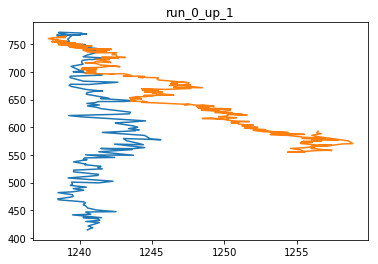

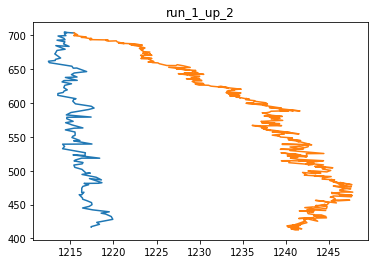

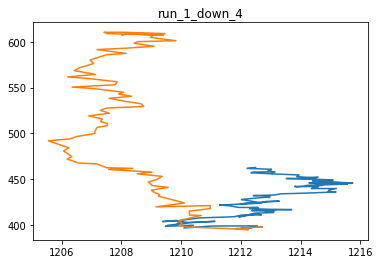

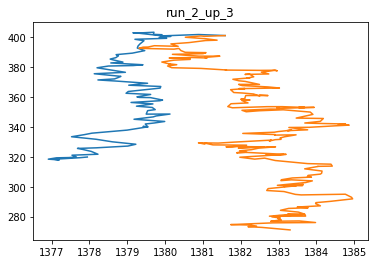

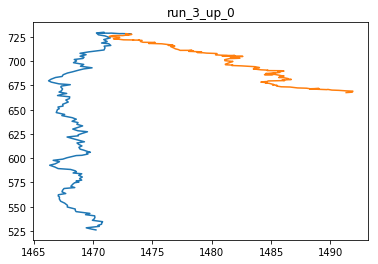

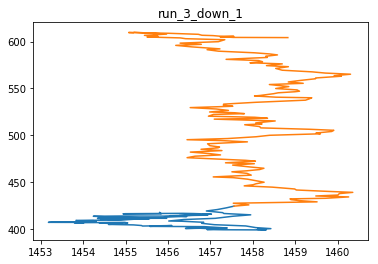

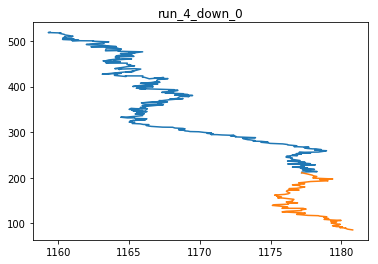

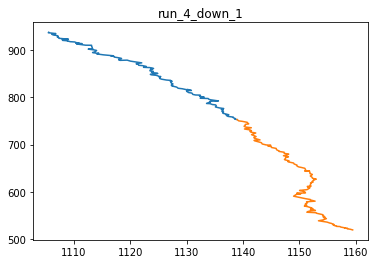

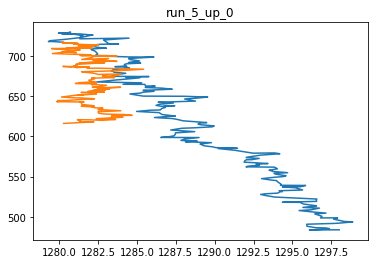

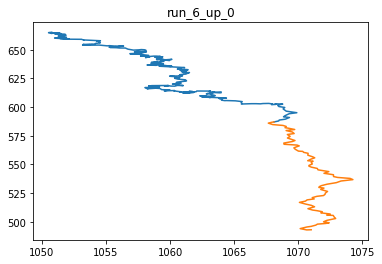

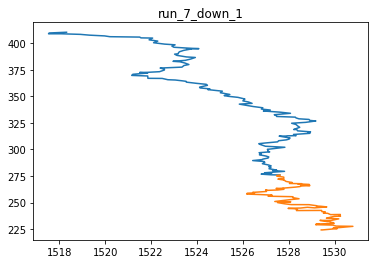

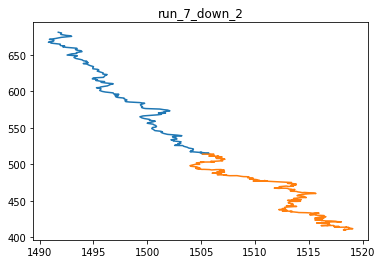

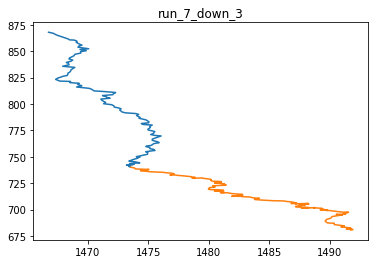

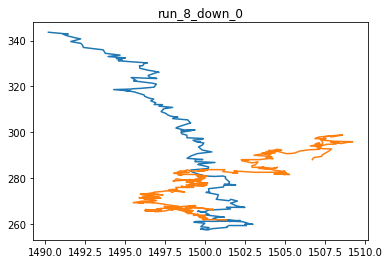

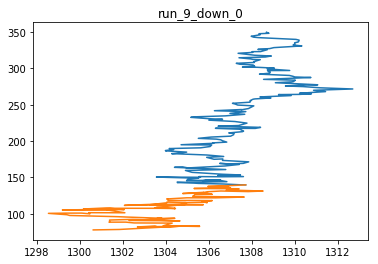

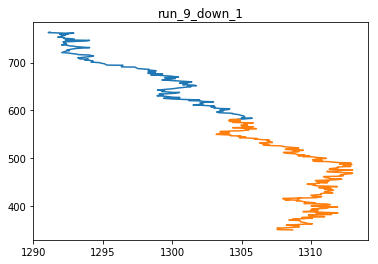

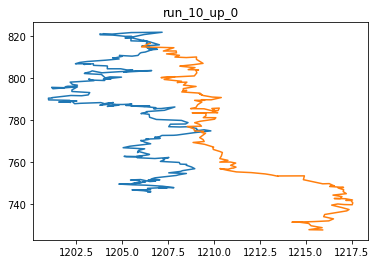

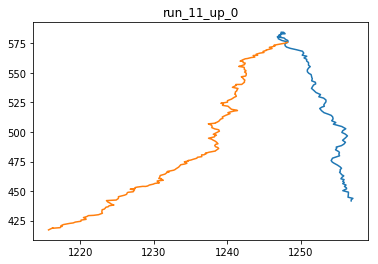

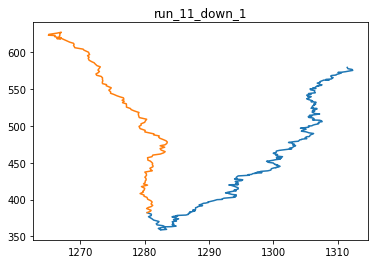

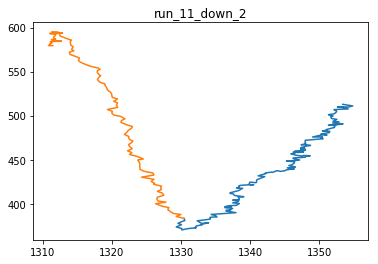

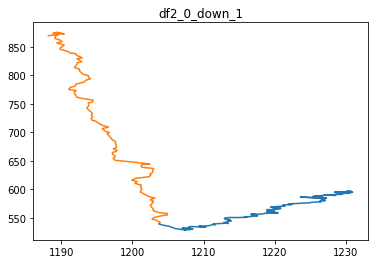

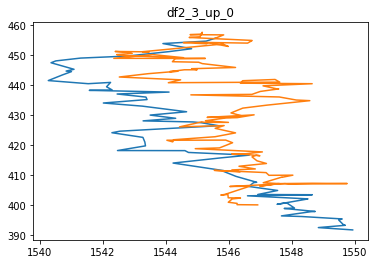

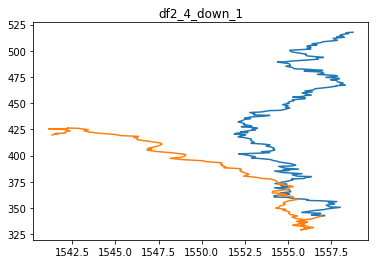

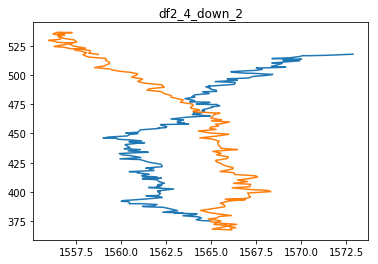

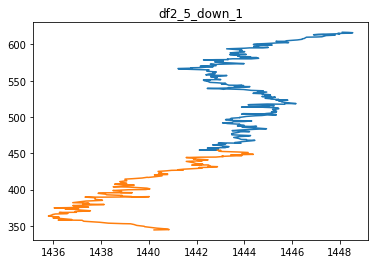

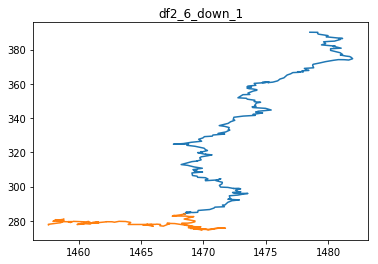

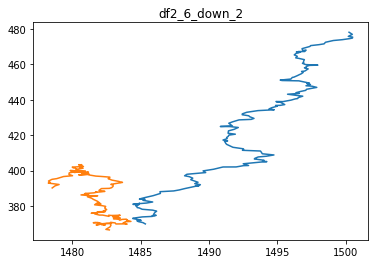

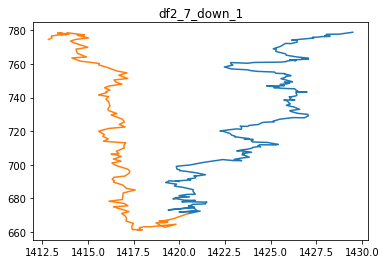

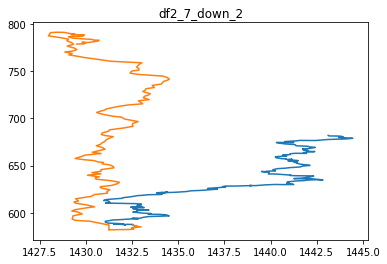

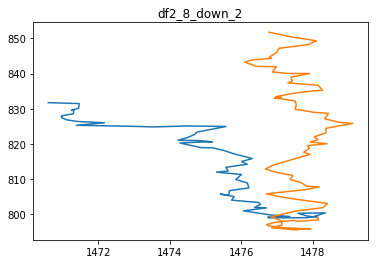

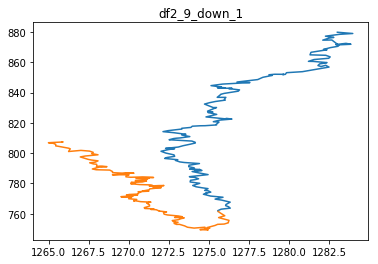

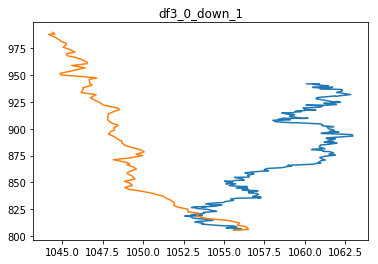

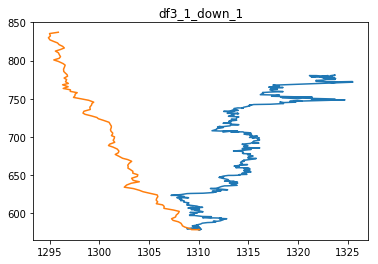

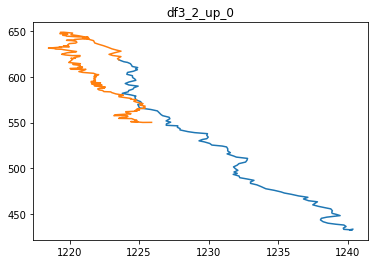

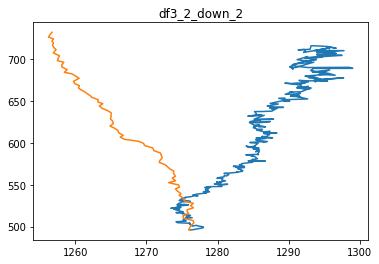

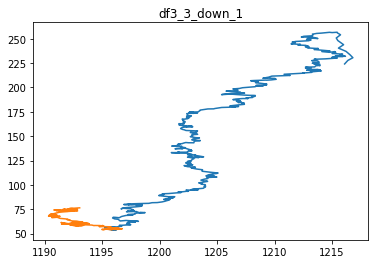

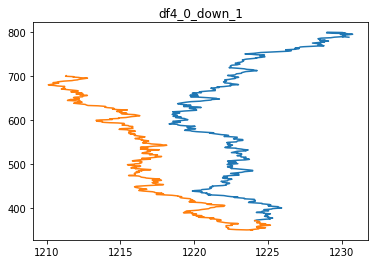

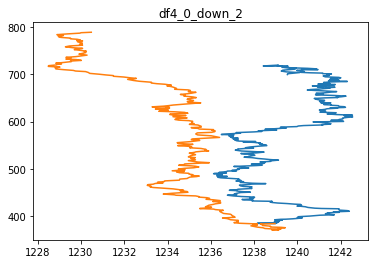

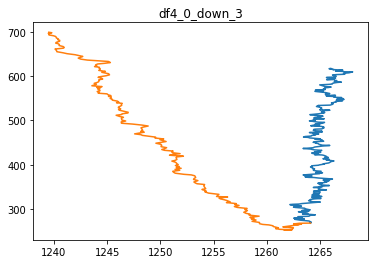

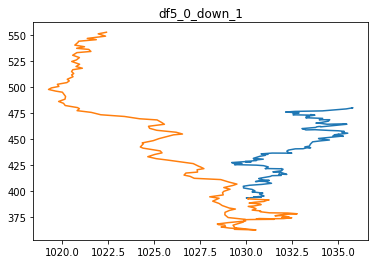

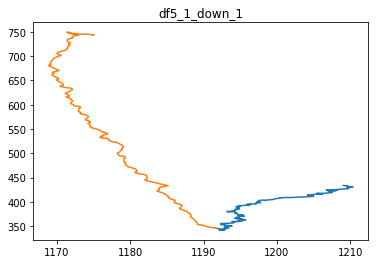

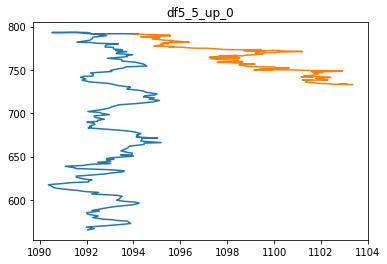

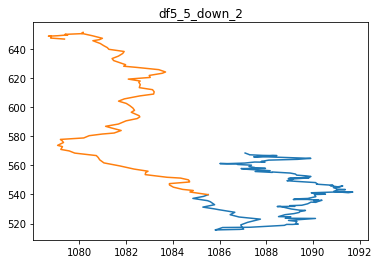

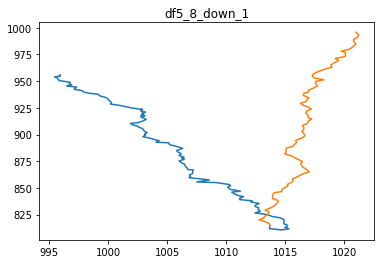

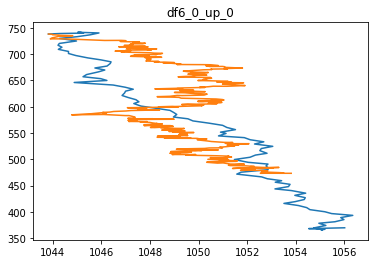

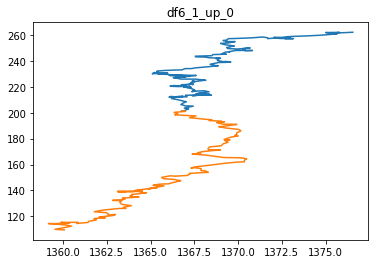

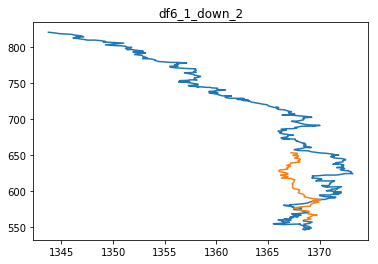

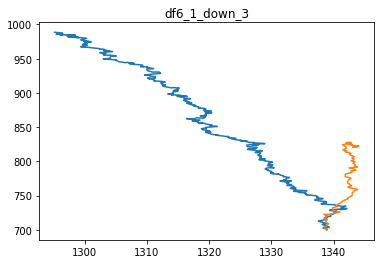

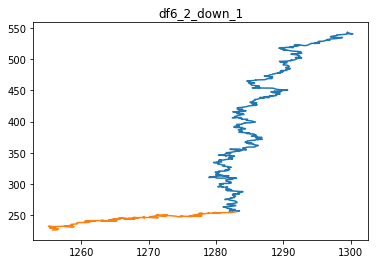

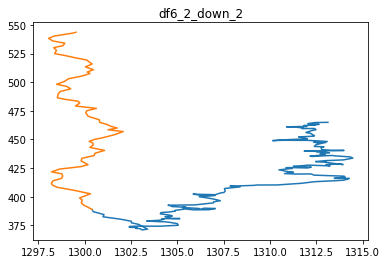

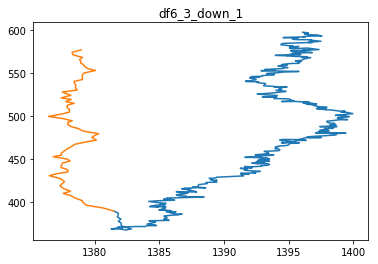

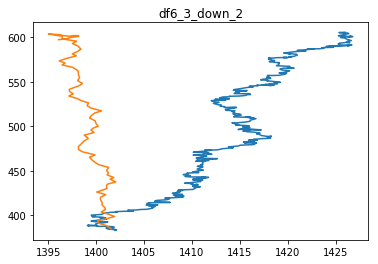

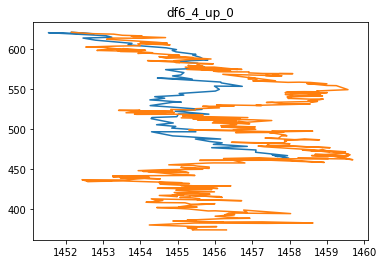

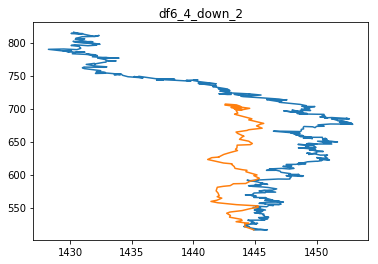

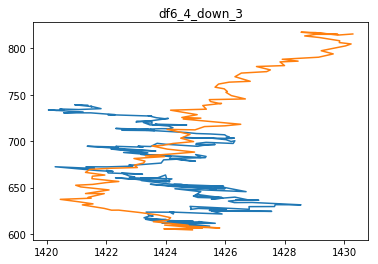

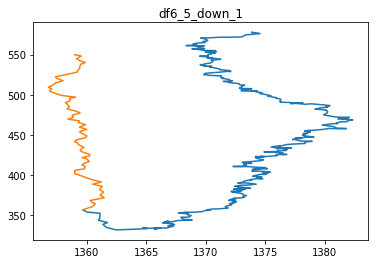

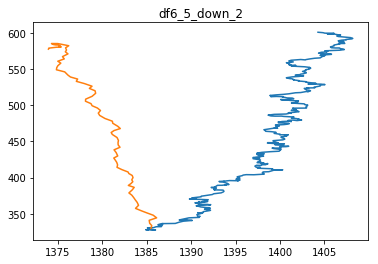

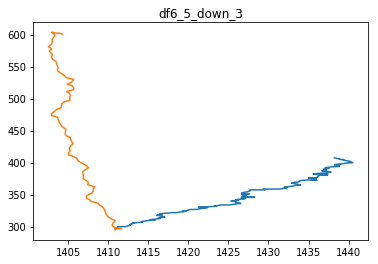

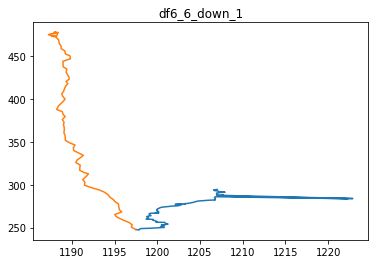

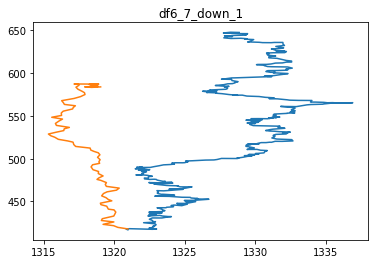

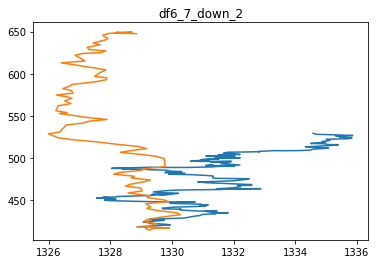

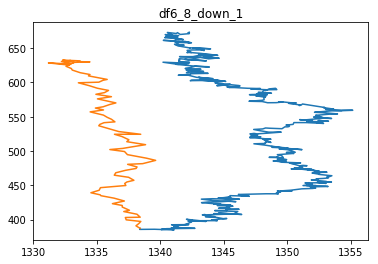

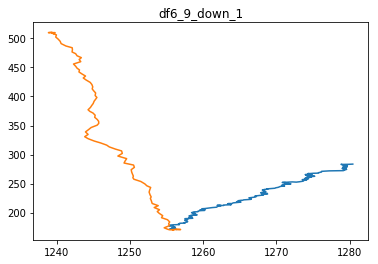

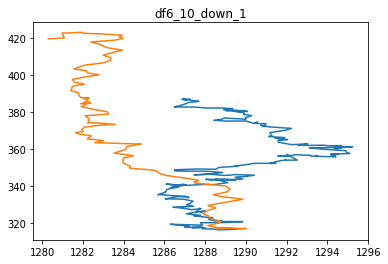

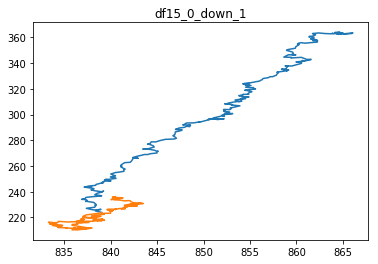

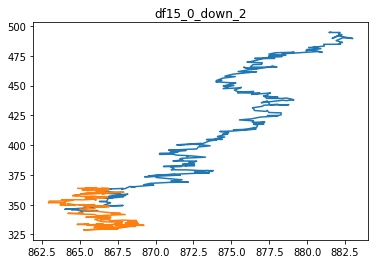

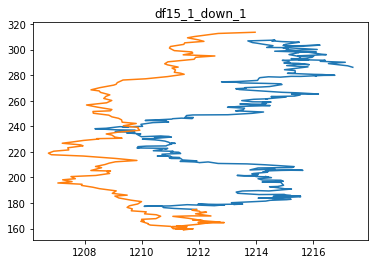

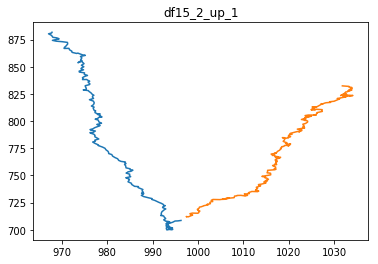

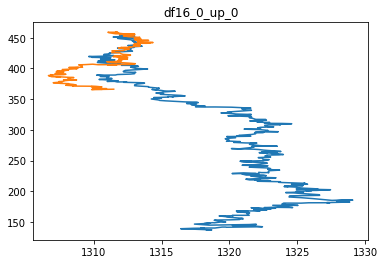

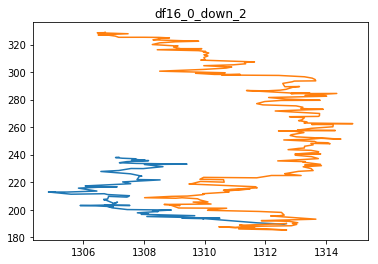

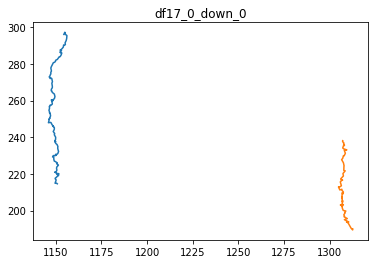

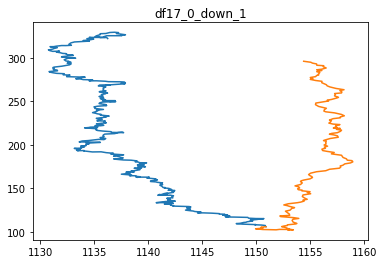

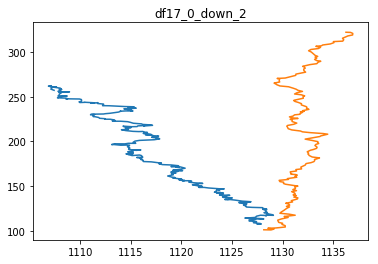

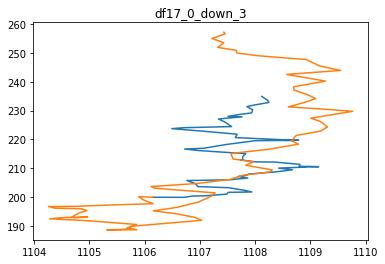

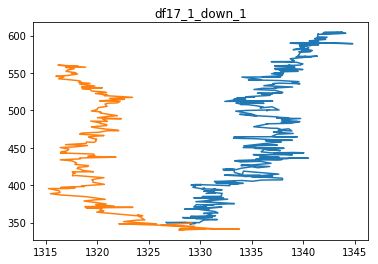

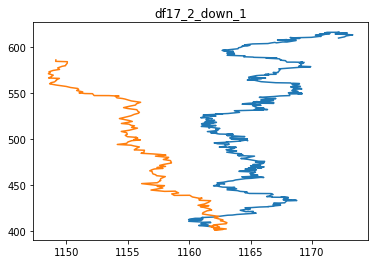

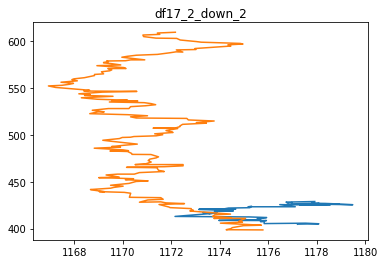

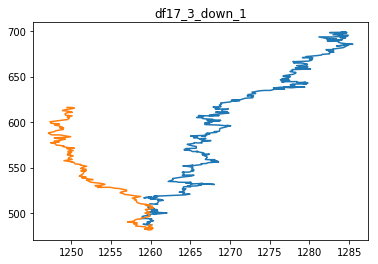

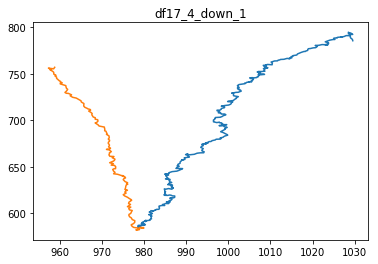

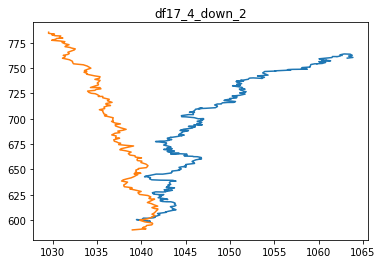

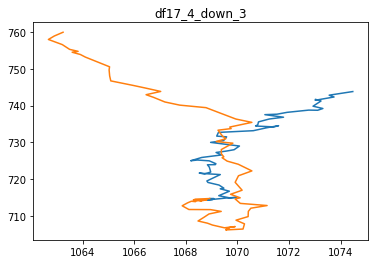

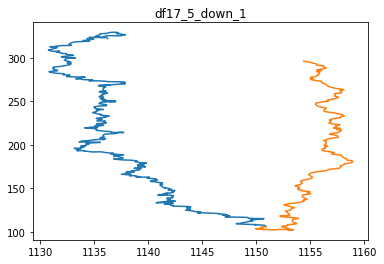

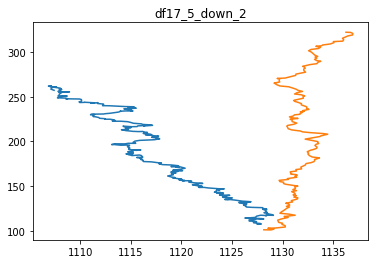

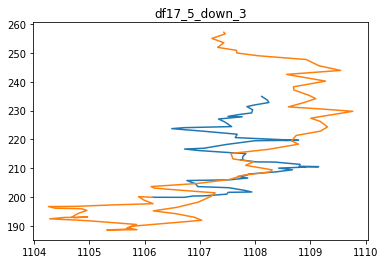

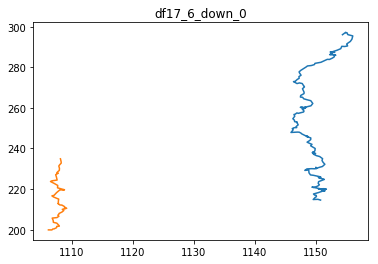

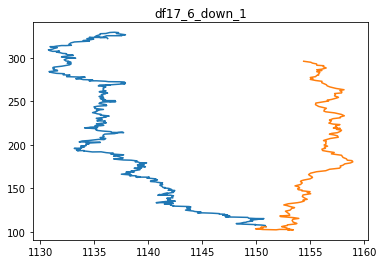

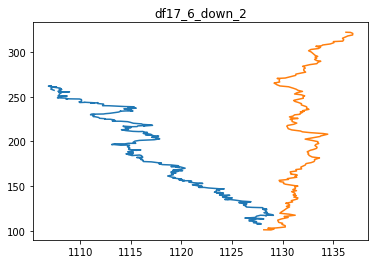

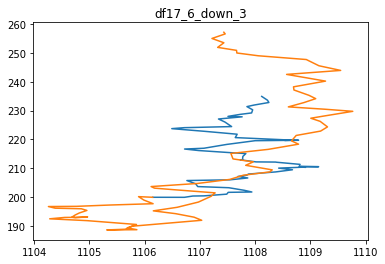

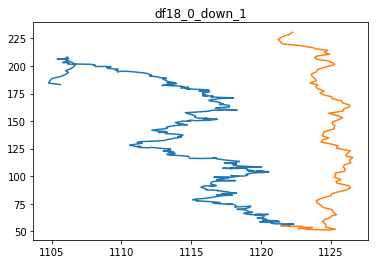

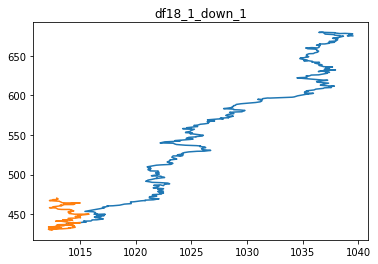

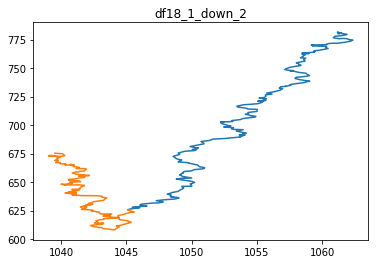

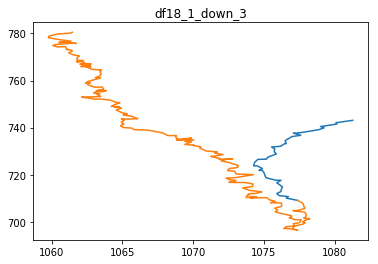

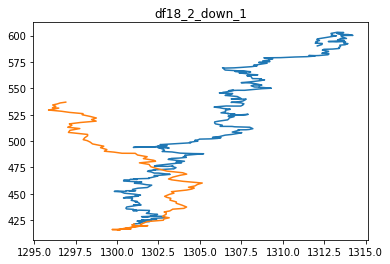

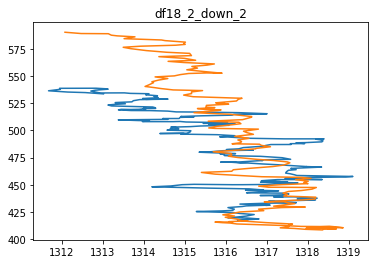

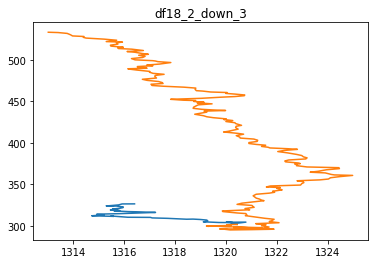

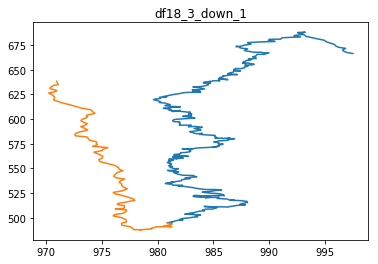

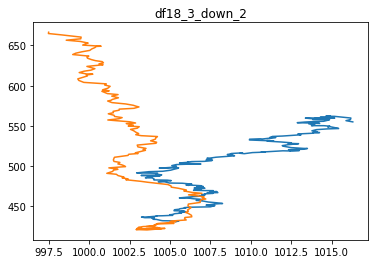

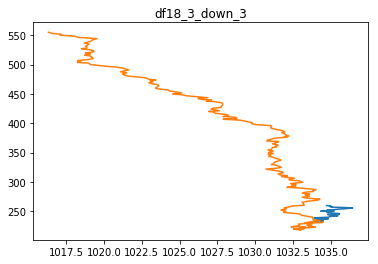

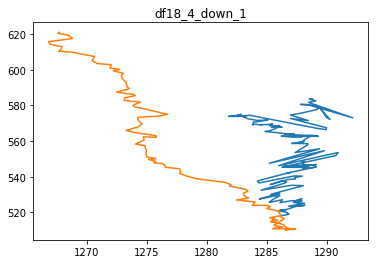

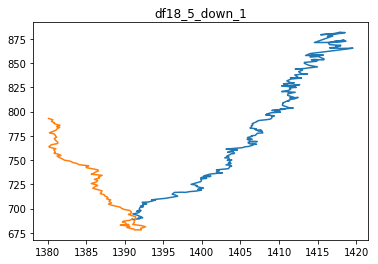

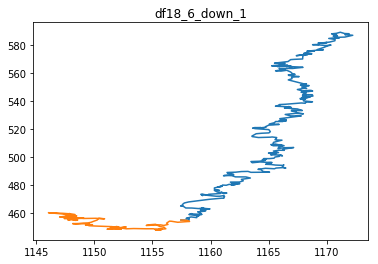

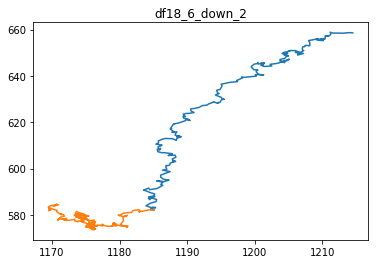

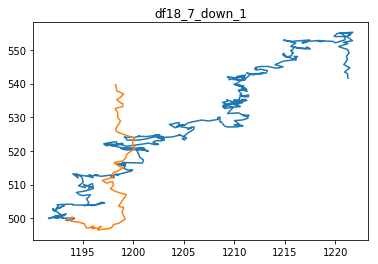

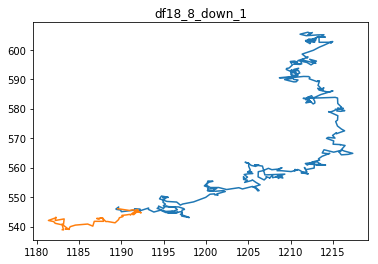

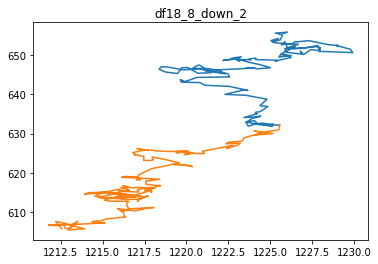

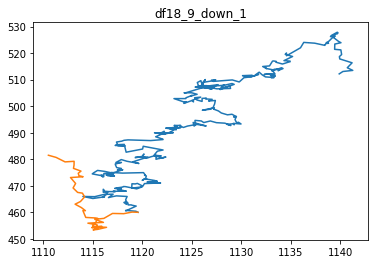

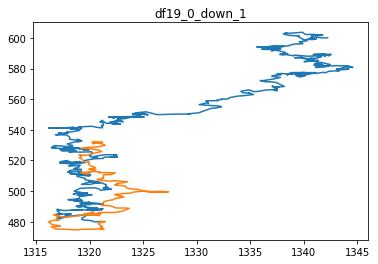

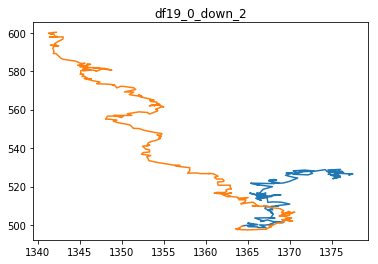

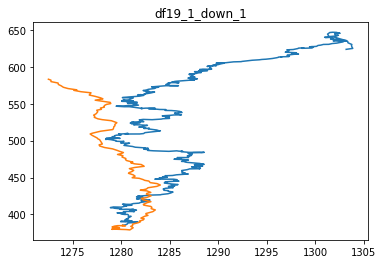

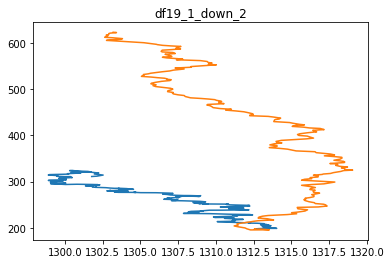

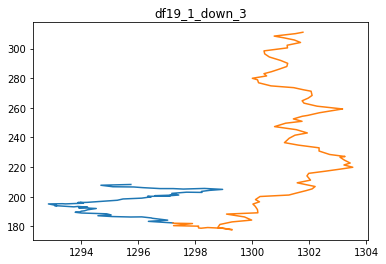

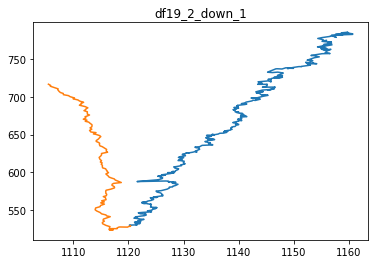

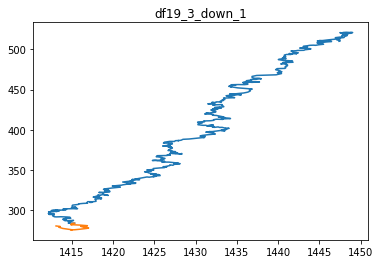

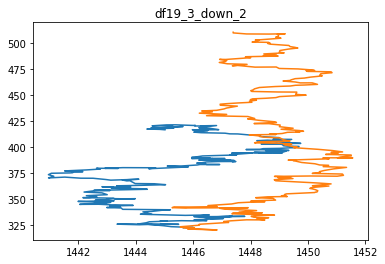

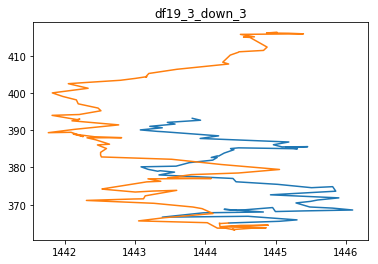

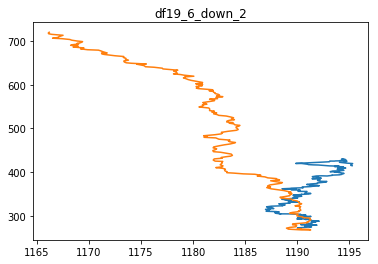

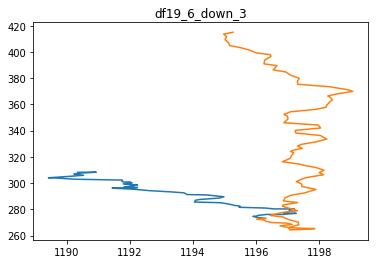

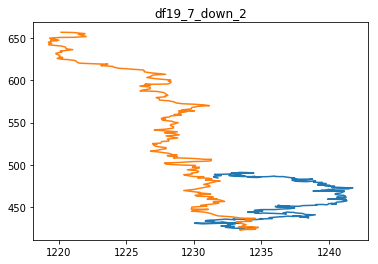

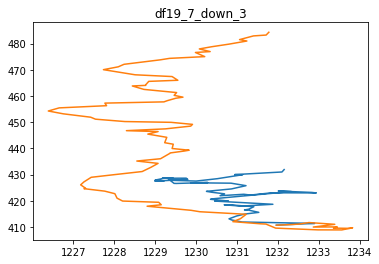

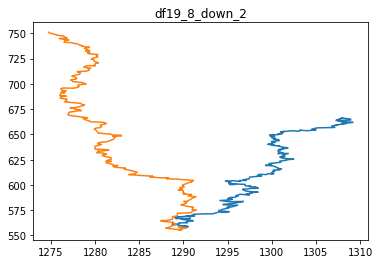

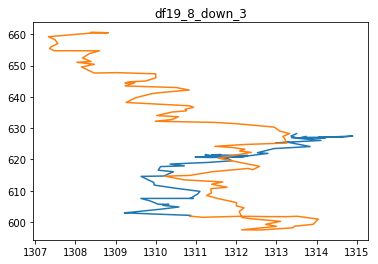

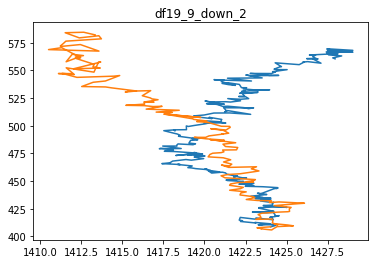

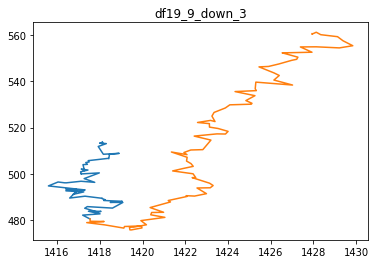

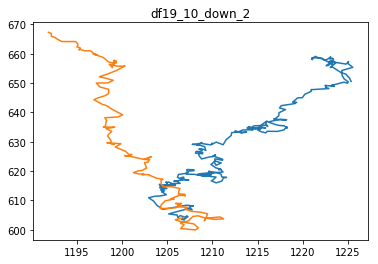

In [3]:
UP = 0
DOWN = 1
last = -1
last_df = None
charges = []
pairs = []
px_per_mm = ufloat(37, 2)*10
fps = 30

def plot_subfig(key, value):
    plt.figure()
    plt.title(key)
    plt.plot(value.x, value.y)
    plt.plot(last_df.x, last_df.y)
    plt.show()

for key, value in di.items():
    
    # Skip this DF if it will be too short.
    if not len(value) > 20:
        last = last_df = None
        continue
        
    # If we hit a particle that isn't the same as what we've been dealing with until this point:
    if last_df is not None and value.particle.iloc[0] != last_df.particle.iloc[0]:
        if len(value):
            last = UP if "up" in key else DOWN
            last_df = value
        else:
            last = last_df = None

    # If we run into a valid DF, save it to one side for processing if it is valid.
    if last == UP and ("down" in key or "gravity" in key):
        # We expect this to be down.
        plot_subfig(key, value)
        charges.append(analyze_df(value, last_df, px_per_mm, fps))
        plt.savefig(key + ".png")
        last_df = value
    elif last == DOWN and "up" in key:
        # We expect this to be up.
        plot_subfig(key, value)
        charges.append(analyze_df(last_df, value, px_per_mm, fps))
        plt.savefig(key + ".png")
        last_df = value
    elif not last:
        last = UP if "up" in key else DOWN
        last_df = value
    else:
        last = last_df = None

The radius of the oil drop is given as
$$
a = \sqrt{\left(\frac{b}{2p}\right)^2 + \frac{9\eta v_f}{2g\rho}} - \frac{b}{2p}
$$
where:

$$
\begin{align}
b &=  8.20 x 10^{-3} Pa · m\\
g &= 9.81 m/s\\
p &= \text{barometric pressure in pascals}\\
\rho &= \text{density of oil in } kg/m^3\\
v_f &= \text{velocity of fall in } m/s\\
v_r &= \text{velocity of fall in } m/s
\end{align}
$$

The mass is given by
$$
m = \frac{4\pi a^3 \rho}{3}
$$

and $q$ is given by
$$
q = \frac{mg(v_f + v_r)}{Ev_f}
$$
This is calculated in `analyze_df` using values for the falling and rising velocities that are implicitly contained in each `DataFrame`, as they all contain position and time information.

There is "bad" data; we have some particles that keep falling at a constant(ish) rate, even when the paralell-plate capacitor is turned on. This means they are either positively charged, or not charged at all. We can use those zero-charge drops to determine how accurate our measurements are. We know that those are almost definitely supposed to be zero, so they're just showing us the magnitude of error. This is calculated internally by `miltools`, and we get flagged data in the form of `(boolean, ufloat)`

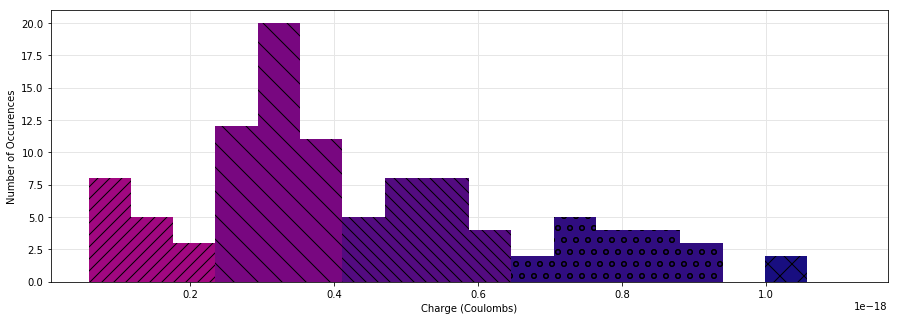

In [4]:
valid_particles = [element[1].n for element in charges if element[0]]

invalid_particles = [element[1].n for element in charges if not element[0]]

expected_err = np.mean(invalid_particles)
bins = np.arange(expected_err, 20*expected_err, expected_err)

plt.figure(figsize=(15, 5))
plt.rc('axes', axisbelow=True)

plt.grid(color='0.9', linestyle='-', linewidth=1)
plt.hist(valid_particles, bins=bins[:4], color = '#a10780', hatch ="//")
plt.hist(valid_particles, bins=bins[3:7], color = '#780780', hatch ="\\")
plt.hist(valid_particles, bins=bins[6:11], color = '#530b80', hatch ="\\\\")
plt.hist(valid_particles, bins=bins[10:16], color = '#300d80', hatch ="o")
plt.hist(valid_particles, bins=bins[15:], color = '#180e80', hatch ="x")
plt.xlabel('Charge (Coulombs)')
plt.ylabel('Number of Occurences')
plt.savefig("hist.png")
plt.show()

In [5]:
# Get the charge values that correspond to our bins.
reduced_1e = [element[1] for element in charges if element[0] and element[1].n <= bins[3]]
reduced_2e = [element[1] for element in charges if element[0] and bins[3] < element[1].n <= bins[6]]
reduced_3e = [element[1] for element in charges if element[0] and bins[6] < element[1].n <= bins[10]]
reduced_4e = [element[1] for element in charges if element[0] and bins[10] < element[1].n <= bins[15]]
reduced_5e = [element[1] for element in charges if element[0] and bins[15] < element[1].n]

# Get the mean of each bin
result_1e = sum(reduced_1e)/len(reduced_1e)
result_2e = sum(reduced_2e)/len(reduced_2e)
result_3e = sum(reduced_3e)/len(reduced_3e)
result_4e = sum(reduced_4e)/len(reduced_4e)
result_5e = sum(reduced_5e)/len(reduced_5e)

# Use these 5 values to produce values for e.
all_res = [result_1e, result_2e/2, result_3e/3, result_4e/4, result_5e/5]
implied_e = sum(all_res)/len(all_res)

# Spit out our results.
print("Raw values:", result_1e, result_2e, result_3e, result_4e, result_5e)
print("Implied values for e:", all_res)
print("Mean:", implied_e)

exp_val = 1.60217662*10**-19
exp_err = (abs(implied_e.n - exp_val)/exp_val)*100
print("Experimental error is ", exp_err,"%")

Raw values: (1.18+/-0.11)e-19 (3.23+/-0.28)e-19 (5.2+/-0.5)e-19 (7.9+/-0.7)e-19 (1.11+/-0.10)e-18
Implied values for e: [1.18268052584788e-19+/-1.1224700158310098e-20, 1.61561307654561e-19+/-1.4073811807150897e-20, 1.7483847432531402e-19+/-1.5101166788640222e-20, 1.9866377838939166e-19+/-1.7128686387021677e-20, 2.213032898301072e-19+/-1.9316786920238344e-20]
Mean: (1.75+/-0.15)e-19
Experimental error is  9.180834605383499 %
